In [1]:
# ──────────────────────────────────────────────────────
# Cell 1: 환경 세팅 (BLAS 스레드, 라이브러리 로드)
# ──────────────────────────────────────────────────────
import os
os.environ["OMP_NUM_THREADS"]        = "1"
os.environ["OPENBLAS_NUM_THREADS"]   = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import numpy as np
import pandas as pd
from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from joblib import Parallel, delayed, parallel_backend
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# ────────────────────────────────────────────────────────────
# Cell 2: Preprocess – lag features, target, Yeo–Johnson transform
# ────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# 1) 데이터 로드 및 정렬
df = pd.read_csv("effective_insulin_results10.csv", parse_dates=["DeviceDtTm"])
df = df.sort_values(["PtID", "DeviceDtTm"])

# 2) lagged exogenous features 생성
df["insulin_z"]     = df["BasalRate"] + df["BolusAmount"]
df["insulin_lag10"] = df.groupby("PtID")["insulin_z"].shift(10)   # 50분
df["carb_z"]        = df["CarbAmount"]
df["carb_lag7"]     = df.groupby("PtID")["carb_z"].shift(7)       # 35분

# 3) centered interaction
mean_ins = df["insulin_lag10"].mean()
mean_carb = df["carb_lag7"].mean()
df["ixc_lag"] = (df["insulin_lag10"] - mean_ins) * (df["carb_lag7"] - mean_carb)

# 4) target: 5분 차분
df["bg_diff"] = df.groupby("PtID")["CGM"].diff()

# 5) NaN 행 제거, 인덱스 재설정
df_feat = df.dropna(subset=["insulin_lag10", "carb_lag7", "ixc_lag", "bg_diff"]) \
            .reset_index(drop=True)

# 6) Yeo–Johnson 변환으로 fat‐tail 완화 + 표준화
pt_yj = PowerTransformer(method="yeo-johnson", standardize=True)
df_feat["bg_diff"] = pt_yj.fit_transform(df_feat[["bg_diff"]])

In [3]:
# ────────────────────────────────────────────────────────────
# Cell 3: Add Fourier terms (period=288, K=5) & global scaling
# ────────────────────────────────────────────────────────────
import numpy as np
from sklearn.preprocessing import StandardScaler

def add_fourier(df, period=288, K=5):
    t = np.arange(len(df))
    for k in range(1, K+1):
        df[f"sin_{k}"] = np.sin(2 * np.pi * k * t / period)
        df[f"cos_{k}"] = np.cos(2 * np.pi * k * t / period)
    return df

# 1) Fourier 고조파 추가
df_feat = add_fourier(df_feat, period=288, K=5)

# 2) exogenous 변수 리스트 재정의
exog_cols = ["insulin_lag10", "carb_lag7", "ixc_lag"] + \
            [c for c in df_feat.columns if c.startswith(("sin_","cos_"))]

# 3) 전역 Z-score 스케일링
scaler = StandardScaler()
df_feat[exog_cols] = scaler.fit_transform(df_feat[exog_cols])

In [4]:
# ──────────────────────────────────────────────────────
# Cell 4: 환자별 학습/검증 split (80/20)
# ──────────────────────────────────────────────────────
train_dict, test_dict = {}, {}
for pid, grp in df_feat.groupby("PtID"):
    n = len(grp)
    split = int(n*0.8)
    train_dict[pid] = grp.iloc[:split]
    test_dict[pid]  = grp.iloc[split:]

In [5]:
# ──────────────────────────────────────────────────────
# Cell 5: 환자별 auto_arima → best_order 하나만 (빈 데이터 건너뜀)
# ──────────────────────────────────────────────────────
from pmdarima import auto_arima
from joblib import Parallel, delayed, parallel_backend

def pick_order(train_df):
    # (1) 훈련 데이터 너무 적으면 건너뜀
    if len(train_df) < 10:
        return None
    y = train_df["bg_diff"]
    X = train_df[exog_cols]
    try:
        m = auto_arima(
            y, exogenous=X,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            d=0,
            seasonal=False,
            stepwise=True,
            error_action="ignore",
            suppress_warnings=True,
            n_jobs=1
        )
        return m.order
    except Exception:
        return None

# (2) train/test 모두 충분한 환자만 대상으로
valid_pids = [pid for pid in train_dict
              if len(train_dict[pid]) >= 10 and len(test_dict.get(pid,[])) >= 5]

with parallel_backend("loky", inner_max_num_threads=1):
    orders_list = Parallel(n_jobs=2)(
        delayed(pick_order)(train_dict[pid]) for pid in valid_pids
    )

# (3) None 제거 후 딕셔너리로 저장
best_per_patient = {
    pid: ord for pid, ord in zip(valid_pids, orders_list) if ord is not None
}

print("적용된 환자 수:", len(best_per_patient))
print("예시 (PtID → order):", list(best_per_patient.items())[:5])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/

적용된 환자 수: 91
예시 (PtID → order): [(1, (1, 0, 1)), (2, (0, 0, 0)), (3, (0, 0, 0)), (4, (0, 0, 0)), (5, (1, 0, 2))]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/

In [6]:
# ──────────────────────────────────────────────────────
# Cell 6: 전 구간 재적합 → 인슐린 계수 추출
# ──────────────────────────────────────────────────────
results = []
for pid, order in best_per_patient.items():
    grp = df_feat[df_feat["PtID"] == pid]
    res = SARIMAX(
        grp["bg_diff"],
        exog=grp[exog_cols],
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    results.append({
        "PtID": pid,
        "order": order,
        "insulin_coef": res.params.get("insulin_lag10", np.nan)
    })

coef_df = pd.DataFrame(results)
coef_df.to_csv("patient_quickarima_coefs2.csv", index=False)
coef_df.head()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and w

,PtID,order,insulin_coef
0,1,"(1, 0, 1)",-0.177476
1,2,"(0, 0, 0)",0.110160
2,3,"(0, 0, 0)",-0.228196
3,4,"(0, 0, 0)",-0.117319
4,5,"(1, 0, 2)",-0.675121


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


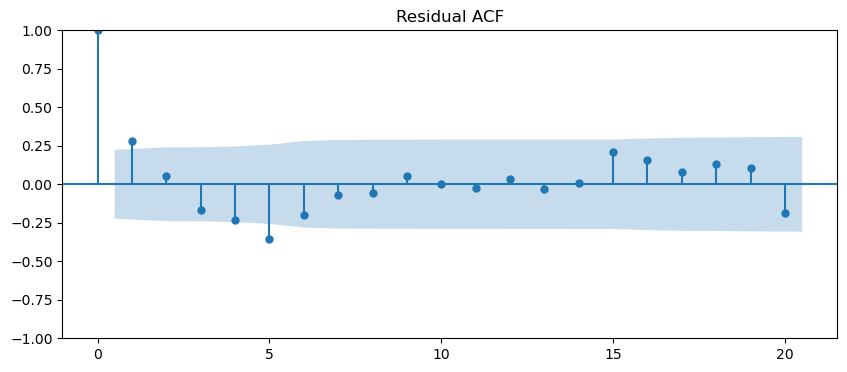

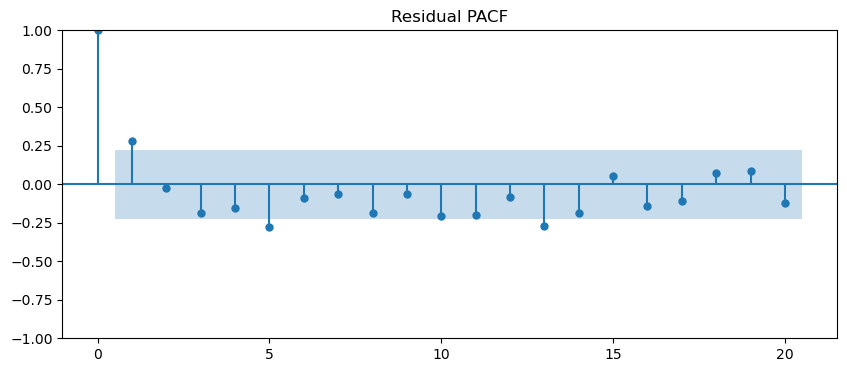

Ljung-Box Test:
      lb_stat  lb_pvalue
10  28.475779   0.001514
20  42.942523   0.002080
Jarque–Bera p-value: 0.441
Shapiro–Wilk p-value: 0.857


In [31]:
# Cell 12: 대표 환자 잔차 진단
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 대표 환자 선택
pid   = list(best_per_patient.keys())[27]
order = best_per_patient[pid]
grp   = df_feat[df_feat['PtID'] == pid]

# 모델 적합 (full data)
res   = SARIMAX(
            grp['bg_diff'],
            exog=grp[exog_cols],
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
resid = res.resid

# ACF / PACF 플롯
plt.figure(figsize=(10,4))
plot_acf(resid, lags=20, ax=plt.gca())
plt.title(f'Residual ACF')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(resid, lags=20, ax=plt.gca())
plt.title(f'Residual PACF')
plt.show()

# Ljung–Box 검정
lb = acorr_ljungbox(resid, lags=[10,20], return_df=True)
print("Ljung-Box Test:")
print(lb)

# 정규성 검정
jb_stat, jb_p, *_ = jarque_bera(resid)
sw_stat, sw_p     = shapiro(resid)
print(f"Jarque–Bera p-value: {jb_p:.3f}")
print(f"Shapiro–Wilk p-value: {sw_p:.3f}")

In [8]:
# Cell 13: 전체 환자 잔차 진단 요약
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX

records = []
for pid, order in best_per_patient.items():
    grp = df_feat[df_feat['PtID'] == pid]
    res = SARIMAX(
            grp['bg_diff'],
            exog=grp[exog_cols],
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
          ).fit(disp=False)
    resid = res.resid
    
    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True).iloc[0]['lb_pvalue']
    jb_p = jarque_bera(resid)[1]
    sw_p = shapiro(resid)[1]
    
    records.append({
        'PtID': pid,
        'lb_pvalue': lb_p,
        'jb_pvalue': jb_p,
        'sw_pvalue': sw_p
    })

diag_df = pd.DataFrame(records)
diag_df['white_noise']  = diag_df['lb_pvalue']  > 0.05
diag_df['normal_jb']    = diag_df['jb_pvalue']  > 0.05
diag_df['normal_sw']    = diag_df['sw_pvalue']  > 0.05

print(f"White-noise pass rate: {diag_df['white_noise'].mean():.2%}")
print(f"JB normality pass rate: {diag_df['normal_jb'].mean():.2%}")
print(f"SW normality pass rate: {diag_df['normal_sw'].mean():.2%}")

diag_df.to_csv('quickarima_resid_diagnostics_summary2.csv', index=False)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and w

White-noise pass rate: 79.12%
JB normality pass rate: 54.95%
SW normality pass rate: 54.95%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Predic

=== Test RMSE ===
count      50.000000
mean      145.391075
std       253.898829
min         2.336848
25%        41.552445
50%        92.240011
75%       165.324230
max      1743.330932 
---
 count     41.000000
mean     130.050989
std      157.876091
min        5.707851
25%       27.669903
50%       91.032958
75%      139.643792
max      768.851852

=== Insulin Coef ===
count    50.000000
mean     -0.250753
std       0.294181
min      -1.052497
25%      -0.402176
50%      -0.208089
75%      -0.120285
max       0.685760 
---
 count    41.000000
mean     -0.188384
std       0.557725
min      -3.014379
25%      -0.328451
50%      -0.177476
75%       0.013394
max       1.156013

T-test RMSE: p = 0.726
Mann-Whitney Insulin Coef: p = 0.159


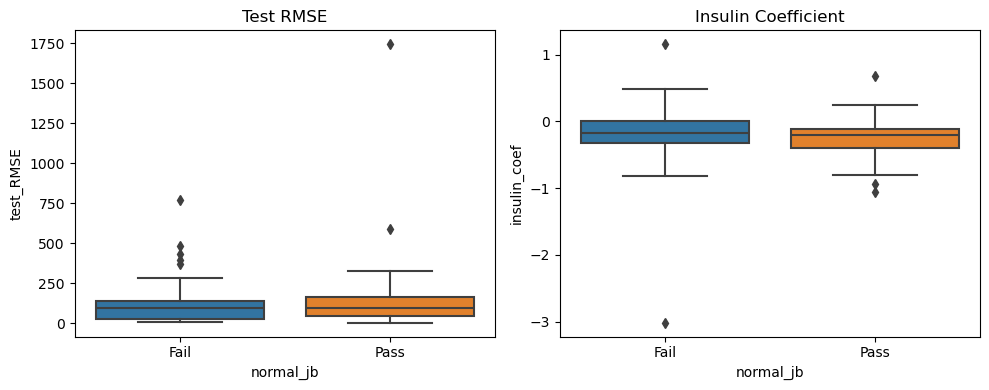

In [9]:
# ────────────────────────────────────────────────
# Cell 14 : “정규성 통과 vs 기각” 성능 · 계수 비교
# ────────────────────────────────────────────────
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 환자별 테스트-RMSE 계산 (best_per_patient 활용)
rmse_records = []
for pid, order in best_per_patient.items():
    te = test_dict[pid]
    tr = train_dict[pid]
    if te.empty:
        continue
    res = SARIMAX(
            tr['bg_diff'], exog=tr[exog_cols],
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
          ).fit(disp=False)
    pred = res.get_forecast(steps=len(te), exog=te[exog_cols]).predicted_mean
    rmse = np.sqrt(mean_squared_error(te['bg_diff'], pred))
    rmse_records.append({'PtID': pid, 'test_RMSE': rmse})

rmse_df = pd.DataFrame(rmse_records)

# 2) 인슐린 계수(이미 추출한 coef_df) + 잔차 진단 결과(diag_df) 결합
merged = coef_df.merge(diag_df, on='PtID') \
                .merge(rmse_df, on='PtID')

# 3) 그룹 분할: 정상 통과 vs 기각 (Jarque-Bera 기준)
g_pass = merged[ merged['normal_jb'] ]
g_fail = merged[~merged['normal_jb'] ]

# 4) 통계 요약
def summary(series):
    return series.describe()[['count','mean','std','min','25%','50%','75%','max']]

print("=== Test RMSE ===")
print(summary(g_pass['test_RMSE']).to_string(), "\n---\n",
      summary(g_fail['test_RMSE']).to_string())

print("\n=== Insulin Coef ===")
print(summary(g_pass['insulin_coef']).to_string(), "\n---\n",
      summary(g_fail['insulin_coef']).to_string())

# 5) 가설검정
rmse_t, rmse_p = ttest_ind(g_pass['test_RMSE'], g_fail['test_RMSE'], equal_var=False)
coef_u, coef_p = mannwhitneyu(g_pass['insulin_coef'], g_fail['insulin_coef'], alternative='two-sided')

print(f"\nT-test RMSE: p = {rmse_p:.3g}")
print(f"Mann-Whitney Insulin Coef: p = {coef_p:.3g}")

# 6) 시각화
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=merged, x='normal_jb', y='test_RMSE', ax=ax[0])
ax[0].set_xticklabels(['Fail','Pass'])
ax[0].set_title("Test RMSE")

sns.boxplot(data=merged, x='normal_jb', y='insulin_coef', ax=ax[1])
ax[1].set_xticklabels(['Fail','Pass'])
ax[1].set_title("Insulin Coefficient")

plt.tight_layout(); plt.show()

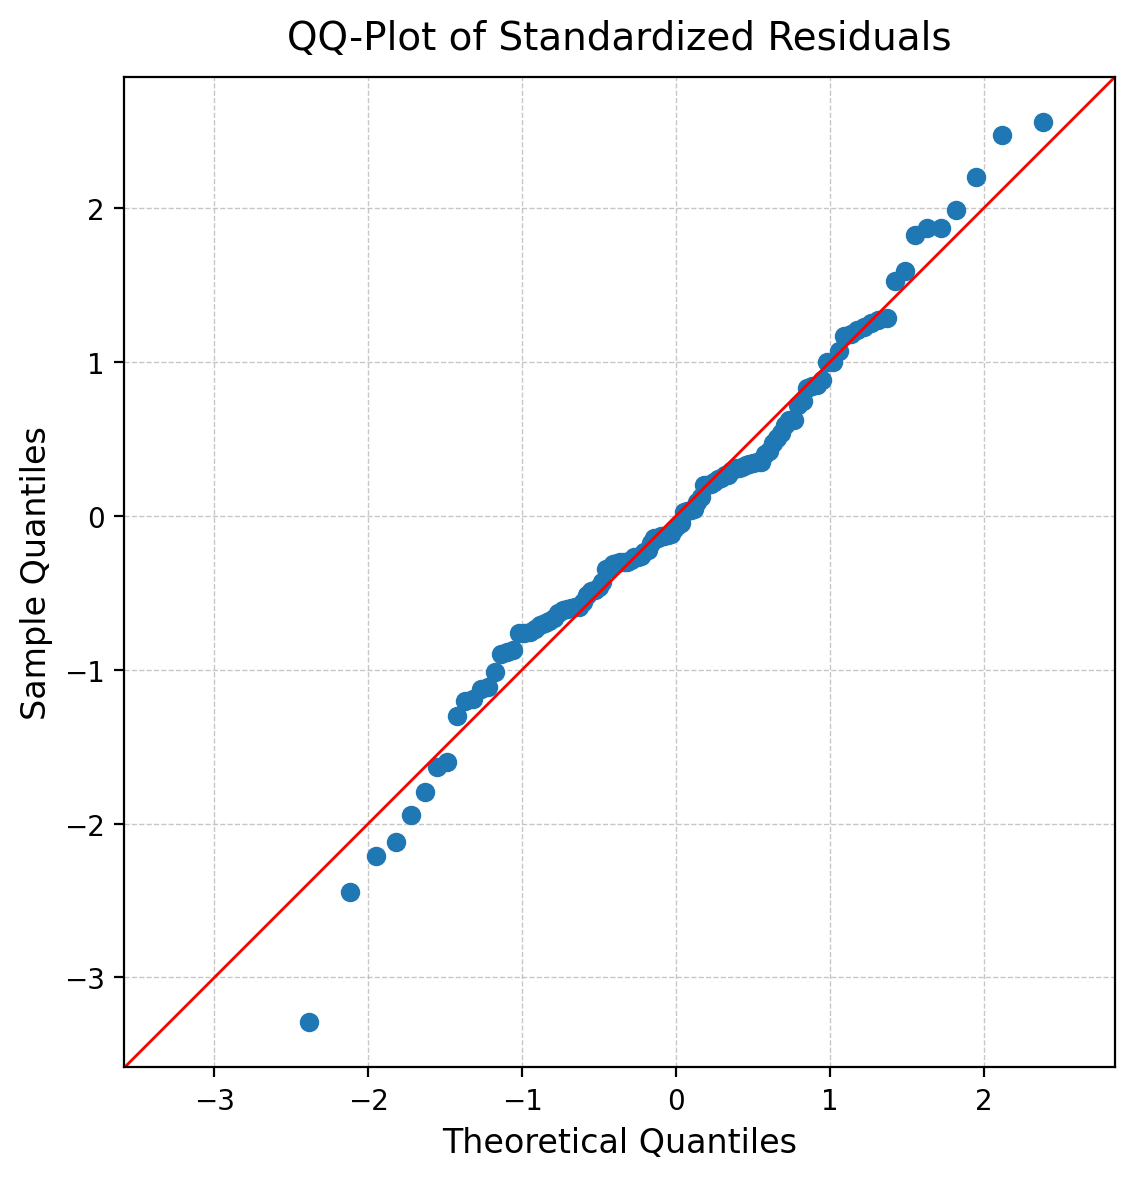

In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# (resids_std가 이미 준비돼 있다고 가정)

# 1) 고DPI figure 생성
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)  # DPI를 200으로 설정

# 2) QQ-plot 그리기
sm.qqplot(resids_std, line='45', fit=True, ax=ax)

# 3) 스타일 커스터마이징
lines = ax.get_lines()
lines[0].set_markersize(6)
lines[1].set_linewidth(1)

ax.set_title("QQ-Plot of Standardized Residuals", fontsize=14, pad=10)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()

# 4) 고해상도 파일 저장 (선택)
plt.savefig("qqplot_highres.png", dpi=300, bbox_inches="tight")  # PNG 300 DPI
# 또는 벡터 포맷으로
# plt.savefig("qqplot_highres.svg", bbox_inches="tight")

plt.show()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


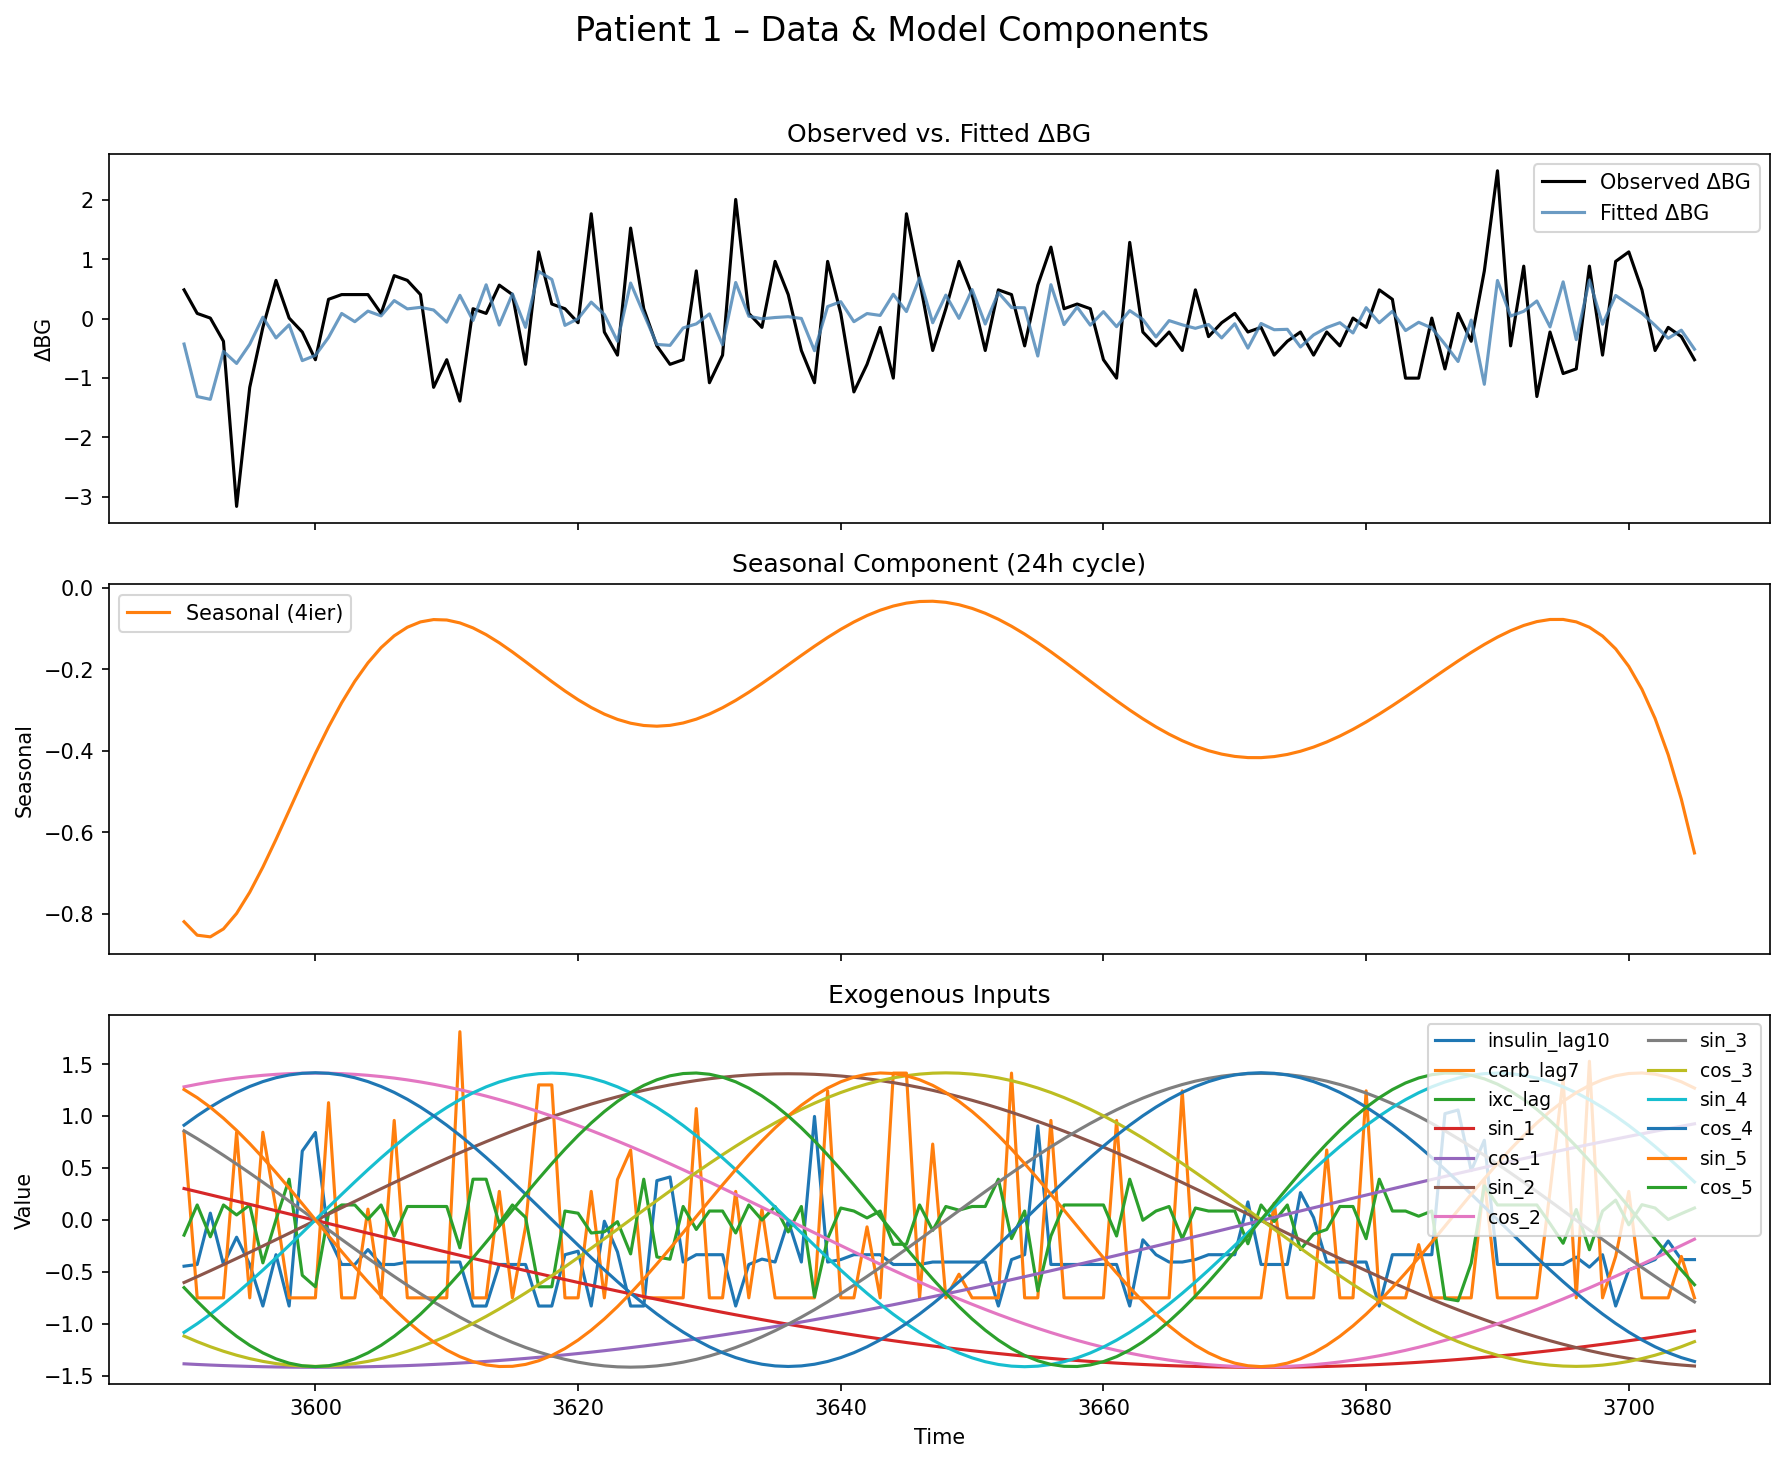

In [22]:
# Cell 13: 대표 환자 시계열 데이터 ⇔ 모델 구성요소 시각화
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ── 1) pid, order, grp, exog_cols는 Cell 12에서 이미 정의됨

# ── 2) 전체 데이터로 SARIMAX 모델 다시 적합
model = SARIMAX(
    grp['bg_diff'],
    exog=grp[exog_cols],
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# ── 3) Fitted values & Seasonal component 계산
fitted     = model.fittedvalues
# Fourier 항 이름만 골라서 계절성 합산
fourier_terms = [c for c in grp.columns if c.startswith('sin_') or c.startswith('cos_')]
seasonal = sum(model.params[c] * grp[c] for c in fourier_terms)

# ── 4) 3×1 패널로 시각화
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True, dpi=150)
fig.suptitle(f'Patient {pid} – Data & Model Components', fontsize=16, y=0.97)

# (a) 관측 ΔBG vs. Fitted ΔBG
axs[0].plot(grp.index, grp['bg_diff'], label='Observed ΔBG', color='black')
axs[0].plot(grp.index, fitted,   label='Fitted ΔBG',   color='steelblue', alpha=0.8)
axs[0].set_ylabel('ΔBG')
axs[0].legend(loc='upper right')
axs[0].set_title('Observed vs. Fitted ΔBG')

# (b) 24시간 계절성( Fourier component )
axs[1].plot(grp.index, seasonal, label='Seasonal (4ier)', color='tab:orange')
axs[1].set_ylabel('Seasonal')
axs[1].legend()
axs[1].set_title('Seasonal Component (24h cycle)')

# (c) 외생변수 (Effective Insulin, Carb lag, 기타)
for col in exog_cols:
    axs[2].plot(grp.index, grp[col], label=col)
axs[2].set_ylabel('Value')
axs[2].legend(ncol=2, fontsize=9)
axs[2].set_title('Exogenous Inputs')

plt.xlabel('Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


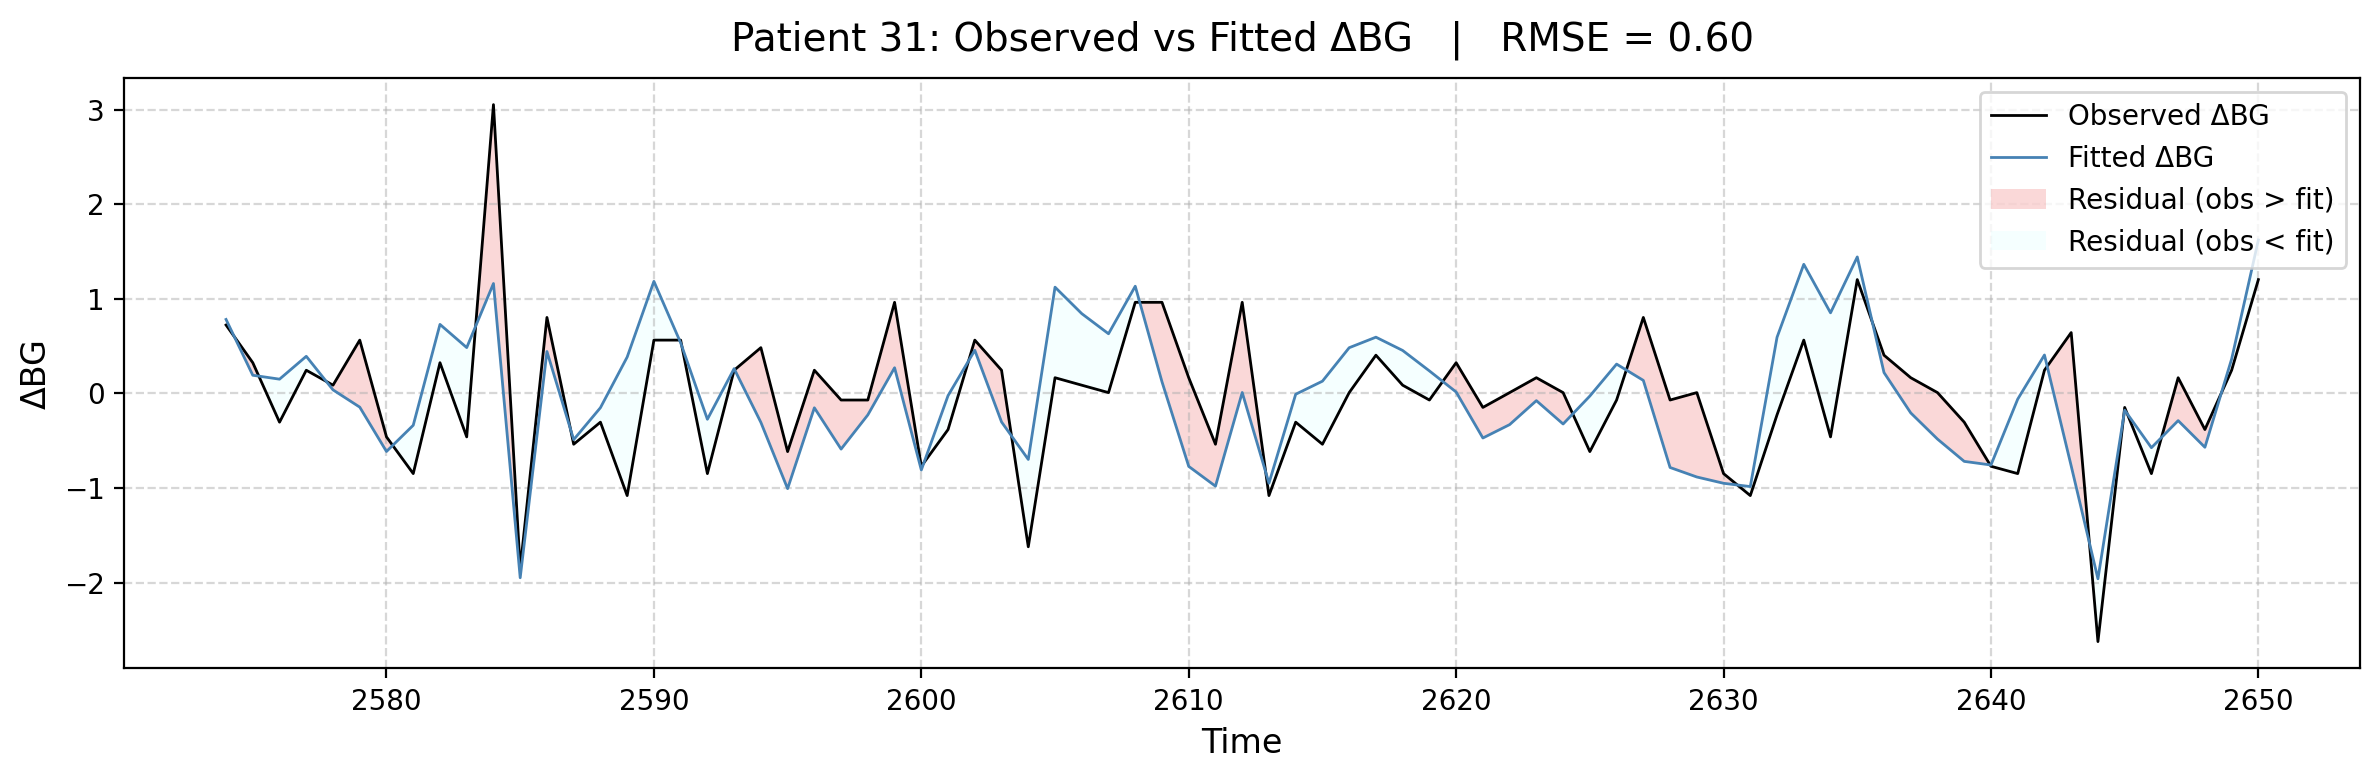

In [26]:
# Cell 14: Observed vs. Fitted ΔBG 상세 시각화
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) 동일 pid, order, grp, exog_cols 사용
pid   = list(best_per_patient.keys())[27]
order = best_per_patient[pid]
grp   = df_feat[df_feat['PtID'] == pid]

#    (Cell12/13에서 이미 정의돼 있다고 가정)
model = SARIMAX(
    grp['bg_diff'],
    exog=grp[exog_cols],
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

fitted = model.fittedvalues
obs    = grp['bg_diff']

# 2) RMSE 계산
rmse = np.sqrt(np.mean((obs - fitted)**2))

# 3) 플롯
plt.figure(figsize=(12,4), dpi=200)
plt.plot(obs.index, obs,    label='Observed ΔBG', color='black', linewidth=1)
plt.plot(obs.index, fitted, label='Fitted ΔBG',   color='steelblue', linewidth=1)

# 4) 잔차 영역 채우기 (Observed–Fitted)
plt.fill_between(
    obs.index,
    obs, fitted,
    where=(obs>=fitted),
    facecolor='lightcoral', alpha=0.3,
    interpolate=True,
    label='Residual (obs > fit)'
)
plt.fill_between(
    obs.index,
    obs, fitted,
    where=(obs< fitted),
    facecolor='lightcyan', alpha=0.3,
    interpolate=True,
    label='Residual (obs < fit)'
)

# 5) 스타일링
plt.title(f'Patient {pid}: Observed vs Fitted ΔBG   |   RMSE = {rmse:.2f}', 
          fontsize=14, pad=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ΔBG',   fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


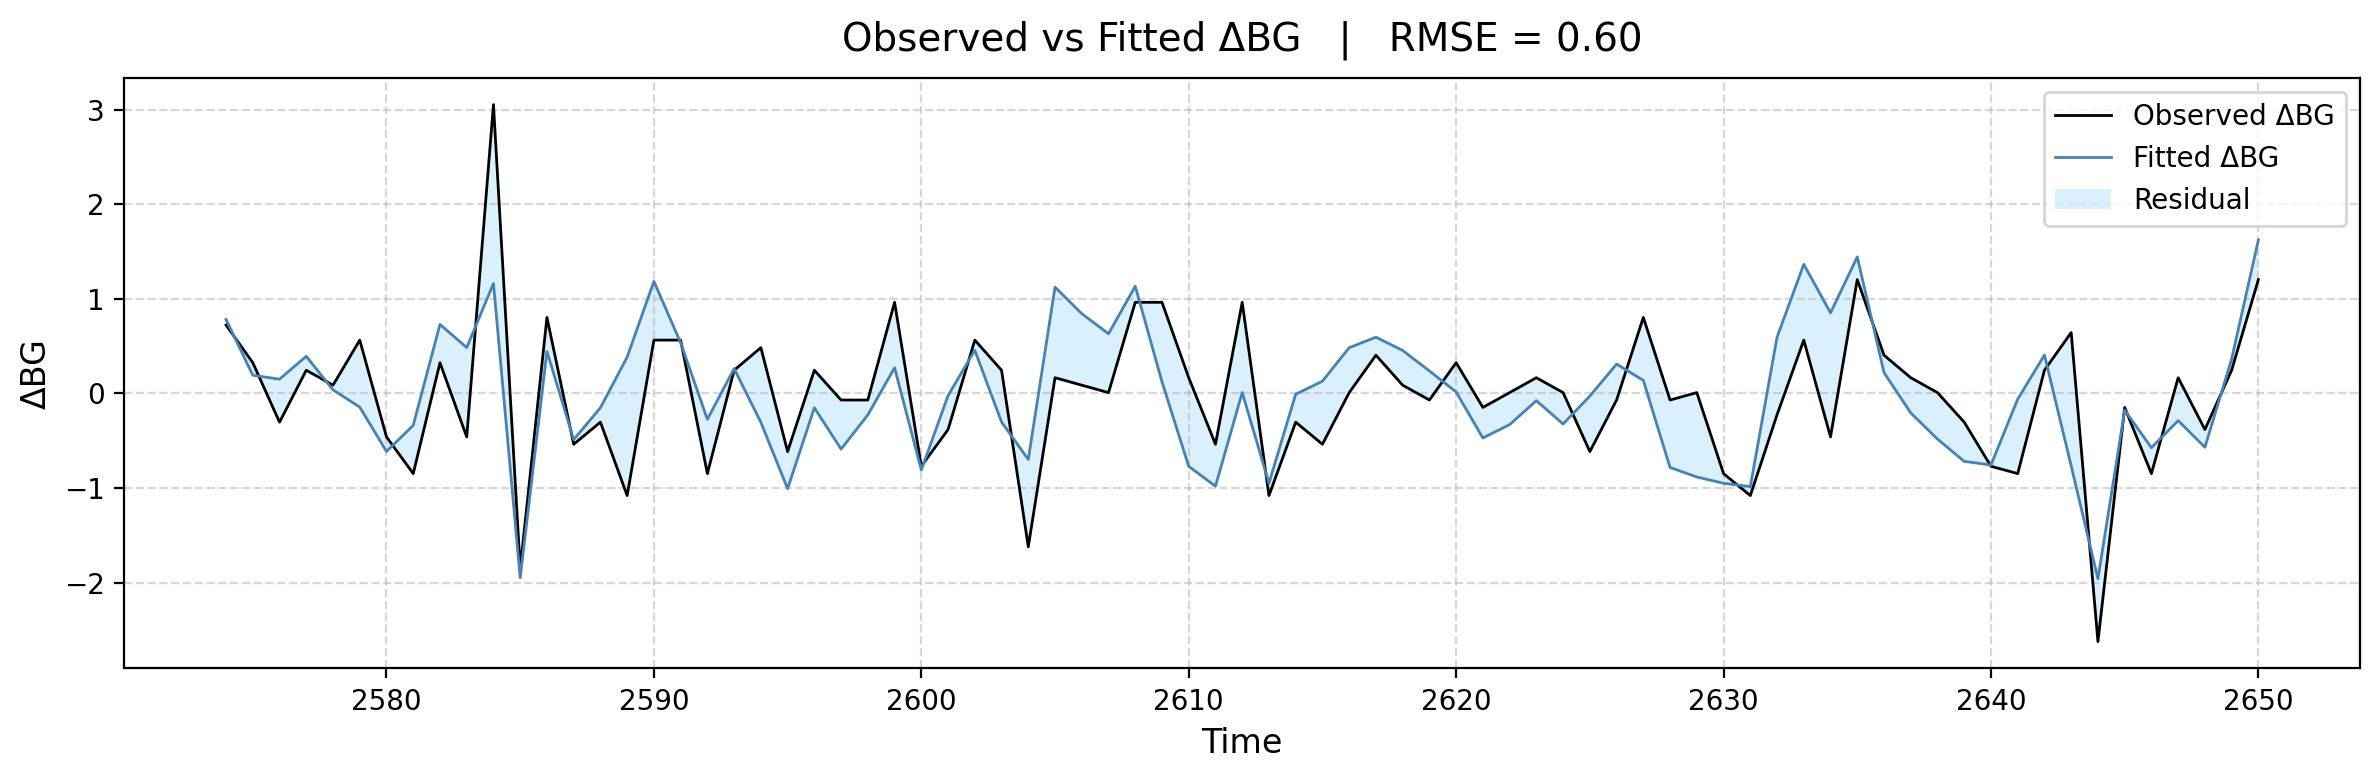

In [ ]:
# ── Version 1: Residual 전체 구간을 연한 하늘색으로 채우기 ─────────────────

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) 대표 환자 셋업 (Cell12/13에서 정의된 변수 재사용)
pid   = list(best_per_patient.keys())[27]
order = best_per_patient[pid]
grp   = df_feat[df_feat['PtID'] == pid]

model = SARIMAX(
    grp['bg_diff'],
    exog=grp[exog_cols],
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

fitted = model.fittedvalues
obs    = grp['bg_diff']
rmse   = np.sqrt(np.mean((obs - fitted)**2))

# 2) 플롯 그리기
plt.figure(figsize=(12,4), dpi=200)
plt.plot(obs.index, obs,    label='Observed ΔBG', color='black',   linewidth=1)
plt.plot(obs.index, fitted, label='Fitted ΔBG',   color='steelblue',linewidth=1)

# Residual 전체 구간 채우기
plt.fill_between(
    obs.index,
    obs, fitted,
    facecolor='lightskyblue',
    alpha=0.3,
    interpolate=True,
    label='Residual'
)

# 스타일링
plt.title(f'Patient {pid}: Observed vs Fitted ΔBG   |   RMSE = {rmse:.2f}',
          fontsize=14, pad=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ΔBG',   fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


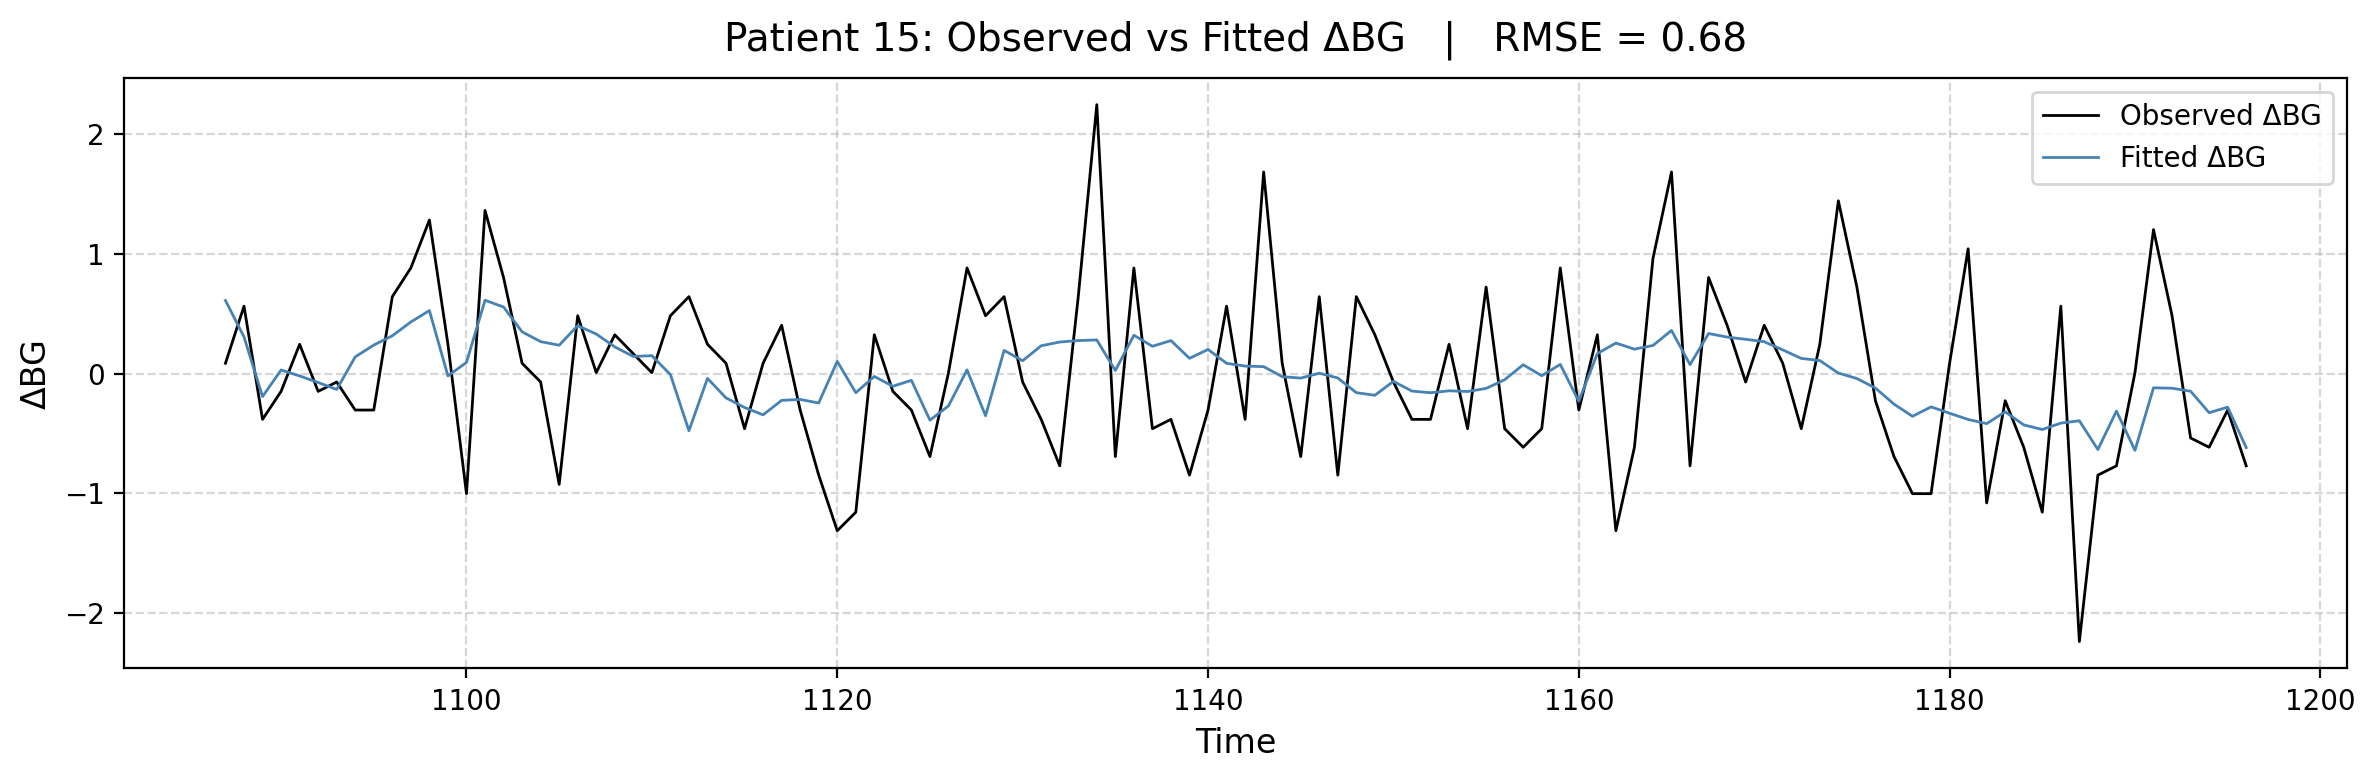

In [37]:
# ── Version 2: Residual 채우기 없이 선만 표시 ─────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) 대표 환자 셋업 (Cell12/13에서 정의된 변수 재사용)
pid   = list(best_per_patient.keys())[12]
order = best_per_patient[pid]
grp   = df_feat[df_feat['PtID'] == pid]

model = SARIMAX(
    grp['bg_diff'],
    exog=grp[exog_cols],
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

fitted = model.fittedvalues
obs    = grp['bg_diff']
rmse   = np.sqrt(np.mean((obs - fitted)**2))

# 2) 플롯 그리기
plt.figure(figsize=(12,4), dpi=200)
plt.plot(obs.index, obs,    label='Observed ΔBG', color='black',   linewidth=1)
plt.plot(obs.index, fitted, label='Fitted ΔBG',   color='steelblue',linewidth=1)

# (Residual 채우기 없음)

# 스타일링
plt.title(f'Patient {pid}: Observed vs Fitted ΔBG   |   RMSE = {rmse:.2f}',
          fontsize=14, pad=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ΔBG',   fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


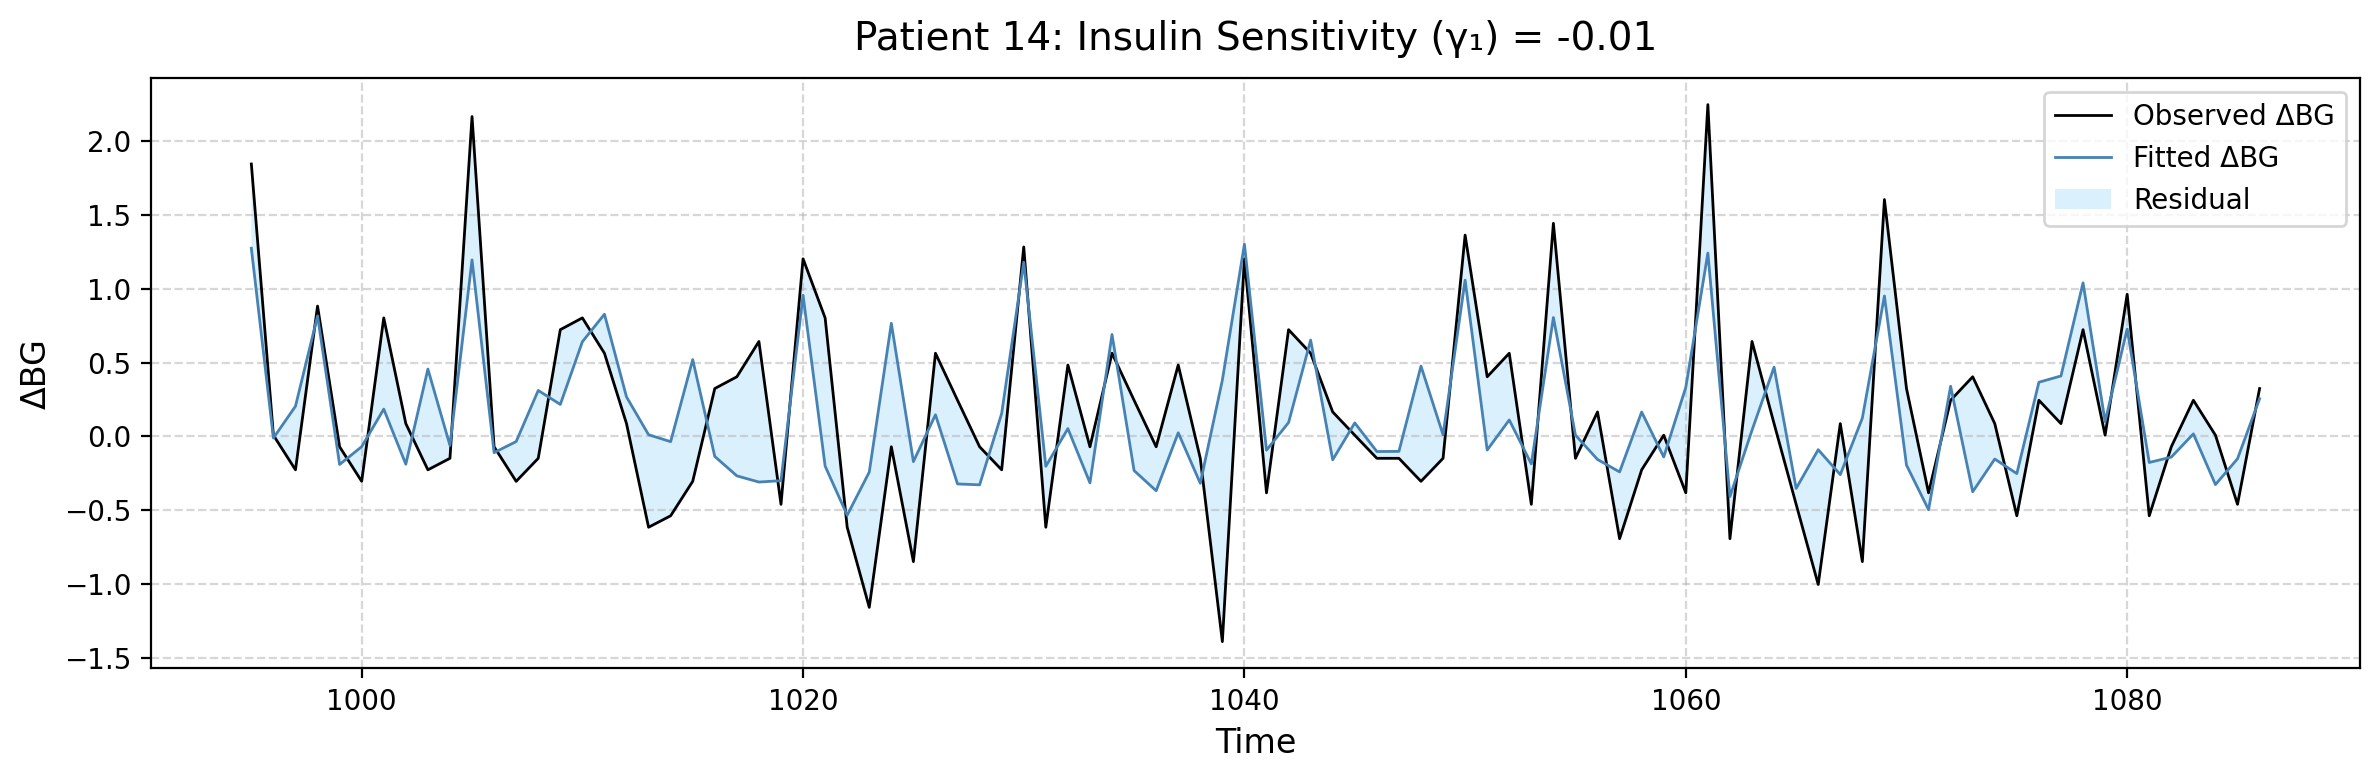

In [38]:
# ── Version 1 (modified): Insulin 민감도 표시 ─────────────────

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1) 대표 환자 셋업
pid   = list(best_per_patient.keys())[11]
order = best_per_patient[pid]
grp   = df_feat[df_feat['PtID'] == pid]

model = SARIMAX(
    grp['bg_diff'],
    exog=grp[exog_cols],
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

fitted        = model.fittedvalues
obs           = grp['bg_diff']
insulin_coef  = model.params.get('insulin_lag10', np.nan)

# 2) 플롯 그리기
plt.figure(figsize=(12,4), dpi=200)
plt.plot(obs.index, obs,    label='Observed ΔBG', color='black',   linewidth=1)
plt.plot(obs.index, fitted, label='Fitted ΔBG',   color='steelblue',linewidth=1)

# Residual 전체 구간 채우기
plt.fill_between(
    obs.index,
    obs, fitted,
    facecolor='lightskyblue',
    alpha=0.3,
    interpolate=True,
    label='Residual'
)

# 스타일링 (인슐린 민감도만 표시)
plt.title(
    f'Patient {pid}: Insulin Sensitivity (γ₁) = {insulin_coef:.2f}',
    fontsize=14, pad=10
)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ΔBG',   fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# ───────────────────────────────────────────────────────────
# Cell 16 (수정판): 대표 환자 선택
# ───────────────────────────────────────────────────────────
import numpy as np

# 1) 결과 병합 (coef_df, rmse_df, diag_df는 이전에 생성됨)
sel = (
    coef_df[['PtID','insulin_coef']]
    .merge(rmse_df, on='PtID')
    .merge(diag_df[['PtID','white_noise','normal_jb']], on='PtID')
)

# 2) '좋은' 환자 필터: 잔차 독립성·정규성 통과 & RMSE 비극단치
q1, q3 = np.percentile(sel['test_RMSE'], [25,75])
iqr    = q3 - q1
thr    = q3 + 1.5*iqr

good = sel[
    (sel['white_noise']) &
    (sel['normal_jb']) &
    (sel['test_RMSE'] <= thr)
].copy()

# 3) 인슐린 민감도 최솟값 (가장 음수, 가장 민감)
pid_most = int(good.loc[good['insulin_coef'].idxmin(), 'PtID'])

# 4) 인슐린 민감도가 0보다 작으면서 0에 가장 가까운 (max negative)
neg = good[good['insulin_coef'] < 0]
pid_closest = int(neg.loc[neg['insulin_coef'].idxmax(), 'PtID'])

print("가장 민감(PtID):", pid_most)
print("0에 가장 근접(PtID):", pid_closest)

가장 민감(PtID): 73
0에 가장 근접(PtID): 14


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


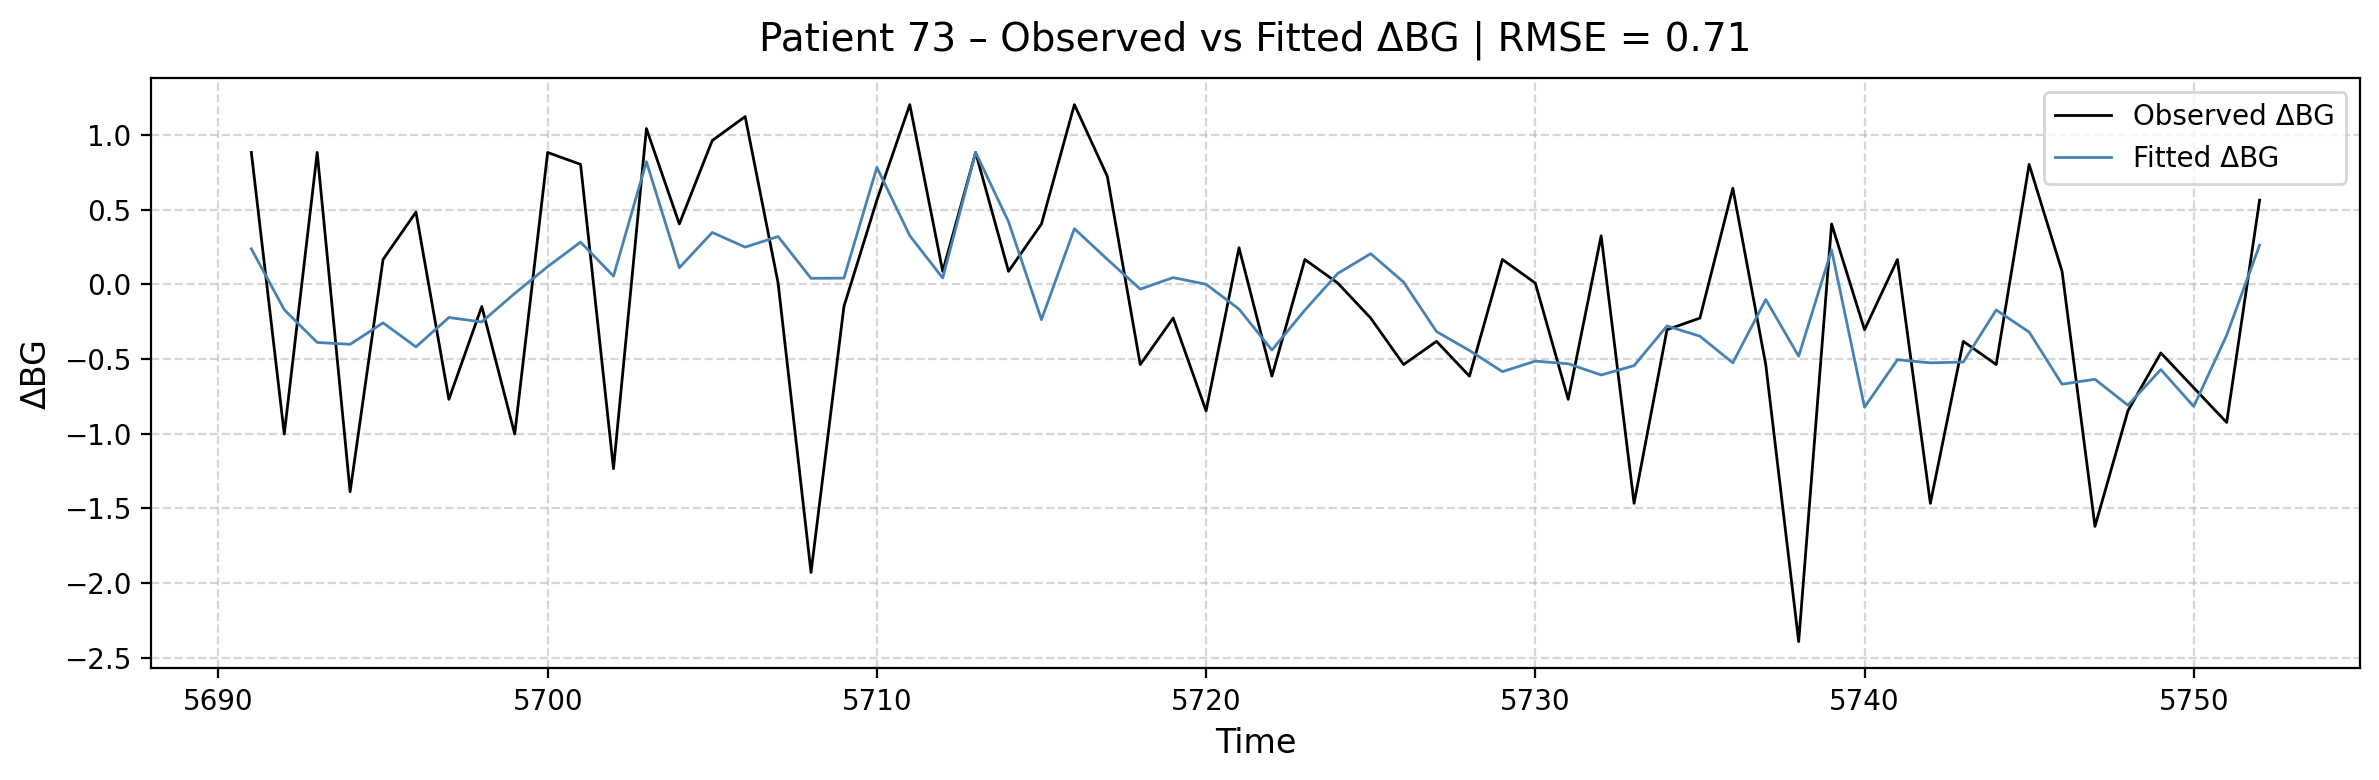

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


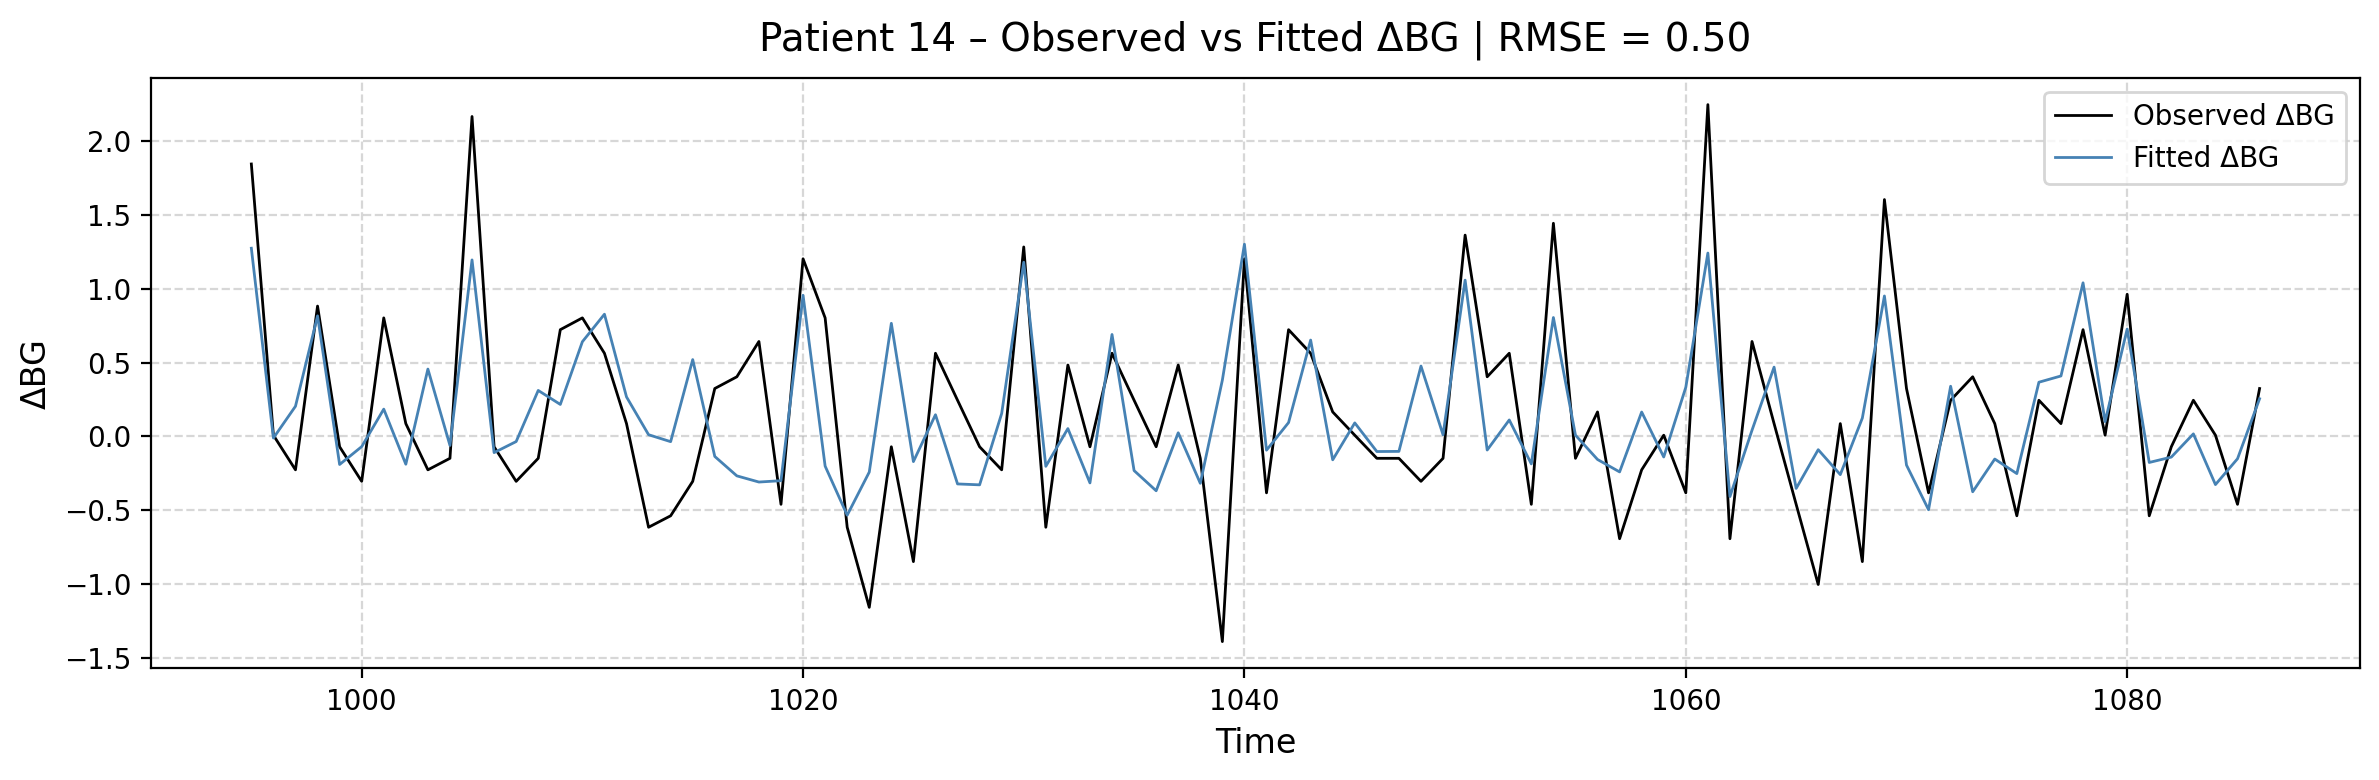

In [34]:
# ───────────────────────────────────────────────────────────
# Cell 17: Observed vs Fitted ΔBG 시계열 플롯 (Residual 없이 선만)
# ───────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

for pid in (pid_most, pid_closest):
    order = best_per_patient[pid]
    grp   = df_feat[df_feat['PtID'] == pid]

    model = SARIMAX(
        grp['bg_diff'],
        exog=grp[exog_cols],
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    fitted = model.fittedvalues
    obs    = grp['bg_diff']
    rmse   = np.sqrt(np.mean((obs - fitted)**2))

    plt.figure(figsize=(12,4), dpi=200)
    plt.plot(obs.index, obs,    label='Observed ΔBG', color='black',   linewidth=1)
    plt.plot(obs.index, fitted, label='Fitted ΔBG',   color='steelblue',linewidth=1)
    plt.title(
        f'Patient {pid} – Observed vs Fitted ΔBG | RMSE = {rmse:.2f}',
        fontsize=14, pad=10
    )
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('ΔBG',   fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()